In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
# reflect the tables
Base = automap_base()
Base.prepare(engine, reflect=True)
inspector = inspect(engine)
columns = inspector.get_table_names()
print(columns)

['measurement', 'station']


In [7]:
# We can view all of the classes that automap found
for column in columns:
    columns_print = inspector.get_columns(column)
    print("----- "+column+" -----")
    for c in columns_print:
        print(c['name'], c["type"])

----- measurement -----
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
----- station -----
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [8]:
# Save references to each table
measurement_ref = Base.classes.measurement
station_ref = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

## Precipitation Analysis 

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database

last_date = session.query(measurement_ref.date).order_by(measurement_ref.date.desc()).first()
last_date = last_date[0]
year = int(last_date[:4])
month = int(last_date[5:7])
day = int(last_date[8:10])
start_date = dt.date(year, month, day) - dt.timedelta(days=365)
print("Retrieve the last 12 months of precipitation data")
print(f'Start date: {start_date}')
print(f'Last date: {last_date}')

Retrieve the last 12 months of precipitation data
Start date: 2016-08-23
Last date: 2017-08-23


In [11]:
# Perform a query to retrieve the data and precipitation scores

prec_data = session.query(measurement_ref.date, measurement_ref.prcp).\
            filter(measurement_ref.date >= start_date).\
            filter(measurement_ref.date <= last_date).\
            order_by(measurement_ref.date).all()

In [12]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date

prec_df = pd.DataFrame(prec_data).set_index('date').\
                        sort_values('date', ascending=True).\
                        dropna().rename(columns={'prcp':'precipitation'})
prec_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79


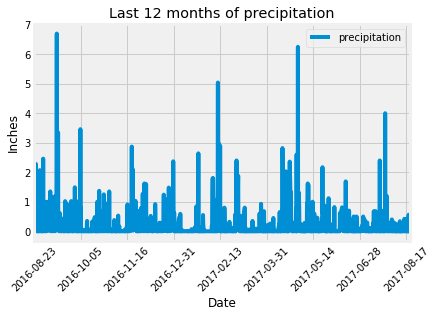

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
prec_df.plot(title='Last 12 months of precipitation')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.xticks(rotation=45)
plt.show()


In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prec_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

In [15]:
# Design a query to show how many stations are available in this dataset?

stations_count = session.query(station_ref.station).group_by(station_ref.station).count()
print(f"Stations available in this dataset: {stations_count}")

Stations available in this dataset: 9


In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations_active = session.query(station_ref.name, measurement_ref.station, func.count(measurement_ref.station)).\
                                filter(station_ref.station == measurement_ref.station).\
                                group_by(measurement_ref.station).\
                                order_by(func.count(measurement_ref.station).desc()).\
                                all()
stations_active

[('WAIHEE 837.5, HI US', 'USC00519281', 2772),
 ('WAIKIKI 717.2, HI US', 'USC00519397', 2724),
 ('KANEOHE 838.1, HI US', 'USC00513117', 2709),
 ('WAIMANALO EXPERIMENTAL FARM, HI US', 'USC00519523', 2669),
 ('MANOA LYON ARBO 785.2, HI US', 'USC00516128', 2612),
 ('KUALOA RANCH HEADQUARTERS 886.9, HI US', 'USC00514830', 2202),
 ('HONOLULU OBSERVATORY 702.2, HI US', 'USC00511918', 1979),
 ('PEARL CITY, HI US', 'USC00517948', 1372),
 ('UPPER WAHIAWA 874.3, HI US', 'USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
resume_active = session.query(station_ref.name,
                              func.count(measurement_ref.station),
                              func.min(measurement_ref.tobs),
                              func.max(measurement_ref.tobs),
                              func.avg(measurement_ref.tobs)).\
                                filter(station_ref.station == measurement_ref.station).\
                                group_by(measurement_ref.station).\
                                order_by(func.count(measurement_ref.station).desc()).limit(1).all()
for record in resume_active:
    station, counter, min_temp, max_temp, avg_temp = record
    print(f"The station {station} which has {counter} observations, registered a minimum temperature of {min_temp}, a maximum temperature of {max_temp} and an average temperature of {avg_temp}")

The station WAIHEE 837.5, HI US which has 2772 observations, registered a minimum temperature of 54.0, a maximum temperature of 85.0 and an average temperature of 71.66378066378067


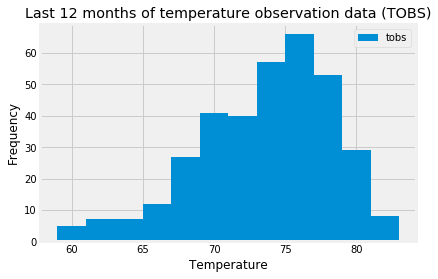

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data = session.query(measurement_ref.tobs).\
            filter(measurement_ref.date >= start_date).\
            filter(measurement_ref.date <= last_date).\
            filter(measurement_ref.station == 'USC00519281').\
            order_by(measurement_ref.date).all()
temp_df = pd.DataFrame(temp_data)
temp_df.plot(title='Last 12 months of temperature observation data (TOBS)', kind='hist', bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()